In [1]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
from src.cohort import load_aki_cohort
from src.utils import add_early_late_dialysis_flags, add_rrt_persistence_near_discharge

# 1. Die Kohorte erst einmal aus der Datenbank in den Arbeitsspeicher laden
df_aki = load_aki_cohort()

# 2. Jetzt kannst du die Zeit-Flags hinzufügen
# Wichtig: add_early_late_dialysis_flags braucht die Spalte 'dialysis', 
# die oft erst durch add_dialysis_flag erstellt wird.
from src.utils import add_dialysis_flag
df_aki = add_dialysis_flag(df_aki)

# Jetzt funktionieren deine Zeit-Analysen
df_aki = add_early_late_dialysis_flags(df_aki, window_hours=24.0)
df_aki = add_rrt_persistence_near_discharge(df_aki)

# 3. Vergleich der Sterblichkeit
summary = df_aki.groupby('early_dialysis')['hospital_mortality'].mean()
print("Sterblichkeitsrate (0 = Keine Dialyse/Spät, 1 = Frühe Dialyse):")
print(summary)

Sterblichkeitsrate (0 = Keine Dialyse/Spät, 1 = Frühe Dialyse):
early_dialysis
0    0.215490
1    0.340351
Name: hospital_mortality, dtype: float64


In [3]:
from src.trajectories import get_parameter_trajectory

# Jetzt kannst du deine Analyse starten
df_crea = get_parameter_trajectory(df_aki, 'creatinine')
df_map = get_parameter_trajectory(df_aki, 'map')

print("Zeitreihen erfolgreich geladen!")

Zeitreihen erfolgreich geladen!


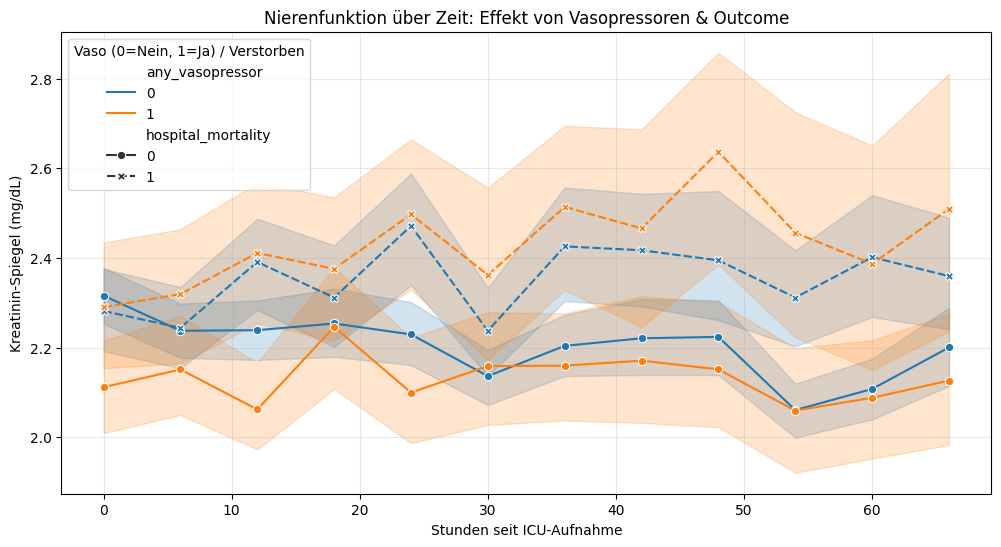

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import add_vasopressor_flags

# 1. Spalten in df_aki ergänzen, falls sie fehlen
# Die Funktion add_vasopressor_flags fügt 'any_vasopressor' hinzu
if 'any_vasopressor' not in df_aki.columns:
    df_aki = add_vasopressor_flags(df_aki, window_hours=24.0)

# Sicherstellen, dass hospital_mortality vorhanden ist 
# (Diese kommt meist direkt aus der load_aki_cohort, aber wir gehen auf Nummer sicher)
if 'hospital_mortality' not in df_aki.columns:
    print("Warnung: hospital_mortality fehlt noch in df_aki!")

# 2. Jetzt erst der Merge
df_plot = df_crea.merge(
    df_aki[['icustay_id', 'any_vasopressor', 'hospital_mortality']], 
    on='icustay_id', 
    how='inner'
)

# 3. Visualisierung (der Rest deines Codes...)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_plot, 
    x='hr_start', 
    y='value', 
    hue='any_vasopressor', 
    style='hospital_mortality', # Gestrichelte Linie für Verstorbene
    markers=True, 
    dashes=True
)

plt.title("Nierenfunktion über Zeit: Effekt von Vasopressoren & Outcome")
plt.xlabel("Stunden seit ICU-Aufnahme")
plt.ylabel("Kreatinin-Spiegel (mg/dL)")
plt.legend(title="Vaso (0=Nein, 1=Ja) / Verstorben")
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# 1. MAP-Daten vorbereiten
df_map_plot = df_map.merge(
    df_aki[['icustay_id', 'any_vasopressor', 'hospital_mortality']], 
    on='icustay_id', 
    how='inner'
)

# 2. Visualisierung des Blutdruck-Verlaufs
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_map_plot, 
    x='hr_start', 
    y='value', 
    hue='any_vasopressor', 
    style='hospital_mortality',
    markers=True
)

# Kritische Grenze in der Medizin: 65 mmHg
plt.axhline(65, color='red', linestyle='--', label='Kritischer MAP (65mmHg)')

plt.title("Blutdruck-Verlauf (MAP) über Zeit")
plt.xlabel("Stunden seit ICU-Aufnahme")
plt.ylabel("Mean Arterial Pressure (mmHg)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'df_map' is not defined

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# WICHTIG: Importiere die Funktion aus deiner neuen Datei
from src.trajectories import add_time_to_vaso

# 1. Die Funktion anwenden, um die Spalte 'hours_until_vaso' zu erzeugen
df_aki = add_time_to_vaso(df_aki)

# 2. Jetzt erst die Filterung und Gruppierung vornehmen
df_timing = df_aki[df_aki['hours_until_vaso'].notna()].copy()

# Hier nutzen wir jetzt die medizinisch etwas feineren Bins, falls du magst:
df_timing['time_group'] = pd.cut(
    df_timing['hours_until_vaso'], 
    bins=[0, 6, 12, 24, 100], 
    labels=['Sehr früh (<6h)', 'Früh (6-12h)', 'Spät (12-24h)', 'Sehr spät (>24h)']
)

# 3. Sterblichkeit pro Zeitgruppe berechnen
timing_summary = df_timing.groupby('time_group', observed=False)['hospital_mortality'].agg(['mean', 'count']).reset_index()
timing_summary['mean'] = timing_summary['mean'] * 100 # In Prozent

# 4. Visualisierung
plt.figure(figsize=(10, 6))
sns.barplot(data=timing_summary, x='time_group', y='mean', palette='Reds_d')
plt.title("Sterblichkeit in Abhängigkeit vom Zeitpunkt der Vasopressorgabe")
plt.ylabel("Hospital Mortality (%)")
plt.xlabel("Zeit von ICU-Aufnahme bis Vaso-Start (Stunden)")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Kleiner Check: Wie viele Patienten sind in den Gruppen?
print(timing_summary)

In [ ]:
from scipy.stats import chi2_contingency

# 1. Eine Kontingenztabelle (Kreuztabelle) erstellen
# Diese zeigt: Wie viele sind in jeder Gruppe verstorben (1) vs. überlebt (0)
contingency_table = pd.crosstab(df_timing['time_group'], df_timing['hospital_mortality'])

# 2. Den Chi-Quadrat-Test durchführen
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("--- Statistische Analyse ---")
print(f"Chi-Quadrat-Wert: {chi2:.4f}")
print(f"P-Wert: {p:.4e}") # Wissenschaftliche Notation für sehr kleine Werte

# 3. Interpretation
alpha = 0.05
if p < alpha:
    print("\nErgebnis: STATISTISCH SIGNIFIKANT")
    print(f"Da der p-Wert ({p:.4e}) kleiner als {alpha} ist, gibt es einen ")
    print("signifikanten Zusammenhang zwischen dem Zeitpunkt der Vasopressorgabe und der Sterblichkeit.")
else:
    print("\nErgebnis: NICHT SIGNIFIKANT")
    print("Die Unterschiede könnten rein zufällig sein.")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Funktionen neu importieren (evtl. Kernel Restart nötig)
from src.trajectories import add_dialysis_flag, add_time_to_vaso

# 1. Sicherstellen, dass die Zeitspalte da ist
if 'hours_until_vaso' not in df_aki.columns:
    df_aki = add_time_to_vaso(df_aki)

# 2. Dialyse-Flag hinzufügen (ruft deine neue Funktion auf)
df_aki = add_dialysis_flag(df_aki)

# 3. Nur Patienten nehmen, die Vasopressoren bekamen
df_dialysis_analysis = df_aki[df_aki['hours_until_vaso'].notna()].copy()

# 4. Gruppen-Einteilung
df_dialysis_analysis['time_group'] = pd.cut(
    df_dialysis_analysis['hours_until_vaso'], 
    bins=[0, 6, 12, 24, 100], 
    labels=['Sehr früh (<6h)', 'Früh (6-12h)', 'Spät (12-24h)', 'Sehr spät (>24h)']
)

# 5. Berechnung der Dialyse-Rate pro Gruppe
# Wir gruppieren nach Zeit und schauen, wie oft 'had_dialysis' vorkommt
dialysis_summary = df_dialysis_analysis.groupby('time_group', observed=False)['had_dialysis'].agg(['mean', 'count']).reset_index()
dialysis_summary['percentage'] = dialysis_summary['mean'] * 100

# 6. Plotten
plt.figure(figsize=(10, 6))
sns.barplot(data=dialysis_summary, x='time_group', y='percentage', palette='Blues_d')
plt.title("Wahrscheinlichkeit einer Dialyse-Pflicht nach Vaso-Timing")
plt.ylabel("Patienten mit Dialyse (%)")
plt.xlabel("Zeit bis zum Vasopressor-Start")
plt.grid(axis='y', alpha=0.3)
plt.show()

print(dialysis_summary)

In [ ]:
# Statistischer Test für die Dialyse
from scipy.stats import chi2_contingency

dialysis_table = pd.crosstab(df_dialysis_analysis['time_group'], df_dialysis_analysis['had_dialysis'])
chi2_d, p_d, _, _ = chi2_contingency(dialysis_table)

print(f"Chi-Quadrat (Dialyse): {chi2_d:.4f}")
print(f"P-Wert (Dialyse): {p_d:.4e}")

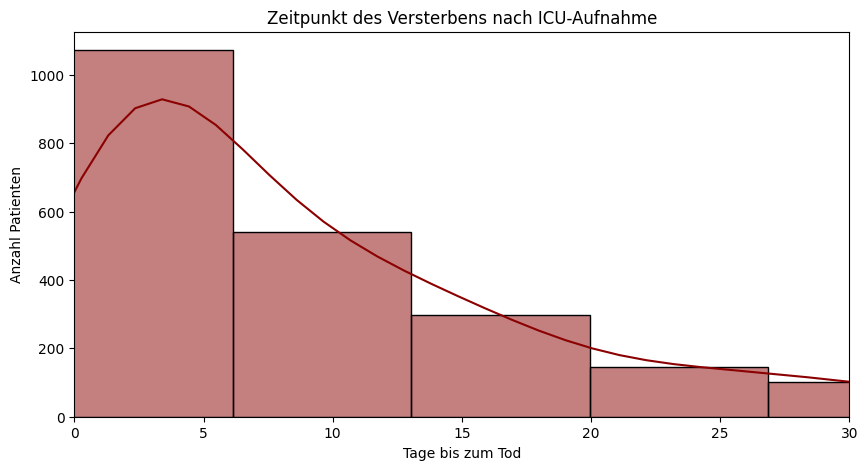

In [8]:
# Berechnung der Zeit bis zum Tod ab ICU-Aufnahme
df_deaths = df_aki[df_aki['hospital_mortality'] == 1].copy()
df_deaths['days_until_death'] = (df_deaths['deathtime'] - df_deaths['intime']).dt.total_seconds() / (3600 * 24)

plt.figure(figsize=(10, 5))
sns.histplot(df_deaths['days_until_death'], bins=30, kde=True, color='darkred')
plt.title("Zeitpunkt des Versterbens nach ICU-Aufnahme")
plt.xlabel("Tage bis zum Tod")
plt.ylabel("Anzahl Patienten")
plt.xlim(0, 30) # Fokus auf die ersten 30 Tage
plt.show()

In [9]:
def get_data_completeness(df_aki, df_measurements, hours=72):
    results = []
    
    for hr in range(0, hours, 6):
        # 1. Wer war zu diesem Zeitpunkt noch in der ICU?
        # (Noch nicht entlassen und noch nicht verstorben)
        still_present = df_aki[
            (df_aki['outtime'] >= df_aki['intime'] + pd.Timedelta(hours=hr)) &
            ((df_aki['deathtime'].isna()) | (df_aki['deathtime'] >= df_aki['intime'] + pd.Timedelta(hours=hr)))
        ]
        num_present = len(still_present)
        
        # 2. Wer von diesen hatte im Fenster hr bis hr+6 eine Messung?
        measured_ids = df_measurements[
            (df_measurements['hr_start'] == hr)
        ]['icustay_id'].nunique()
        
        if num_present > 0:
            percentage = (measured_ids / num_present) * 100
        else:
            percentage = 0
            
        results.append({'hour': hr, 'present': num_present, 'measured': measured_ids, 'completeness_pct': percentage})
    
    return pd.DataFrame(results)

# Anwendung für Kreatinin
df_completeness = get_data_completeness(df_aki, df_crea)

# Visualisierung
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_completeness, x='hour', y='completeness_pct', marker='o', color='green')
plt.title("Datenvollständigkeit (Kreatinin) der anwesenden Patienten")
plt.ylabel("Messungen pro anwesende Patienten (%)")
plt.xlabel("Stunden seit Aufnahme")
plt.ylim(0, 105)
plt.grid(True, alpha=0.3)
plt.show()

print(df_completeness)

NameError: name 'df_crea' is not defined

In [ ]:
import sys
import os

# Fügt das aktuelle Verzeichnis zum Pfad hinzu
sys.path.append(os.getcwd())

# Jetzt sollte der Import funktionieren
from src.trajectories import get_sofa_at_time

# Berechnung der Zeitpunkte
print("Berechne SOFA nach 6h...")
df_sofa_6h = get_sofa_at_time(6)

print("Berechne SOFA nach 12h...")
df_sofa_12h = get_sofa_at_time(12)

print("Berechne SOFA nach 24h...")
df_sofa_24h = get_sofa_at_time(24)

# Jetzt kannst du sie zusammenführen, um die Dynamik zu sehen
# Beispiel:
df_dynamics = df_sofa_6h[['icustay_id', 'sofa']].rename(columns={'sofa': 'sofa_6h'})
df_dynamics = df_dynamics.merge(df_sofa_12h[['icustay_id', 'sofa']].rename(columns={'sofa': 'sofa_12h'}), on='icustay_id')
df_dynamics = df_dynamics.merge(df_sofa_24h[['icustay_id', 'sofa']].rename(columns={'sofa': 'sofa_24h'}), on='icustay_id')

Berechne SOFA nach 6h...


ProgrammingError: (psycopg2.errors.SyntaxError) FEHLER:  Syntaxfehler bei »\«
LINE 3: \i sql/concepts_postgres/postgres-functions.sql
        ^

[SQL: 
    -- Load helper functions (DATETIME_ADD, DATETIME_SUB, DATE_ADD)
\i sql/concepts_postgres/postgres-functions.sql

-- Create schema and set search path
CREATE SCHEMA IF NOT EXISTS mimiciii_derived;
SET search_path TO mimiciii_derived, mimic, public;

-- Load all dependencies
\i sql/concepts_postgres/firstday/urine_output_first_day.sql
\i sql/concepts_postgres/firstday/vitals_first_day.sql
\i sql/concepts_postgres/firstday/gcs_first_day.sql
\i sql/concepts_postgres/firstday/labs_first_day.sql
\i sql/concepts_postgres/firstday/blood_gas_first_day.sql
\i sql/concepts_postgres/firstday/blood_gas_first_day_arterial.sql
\i sql/concepts_postgres/echo_data.sql
\i sql/concepts_postgres/durations/ventilation_classification.sql
\i sql/concepts_postgres/durations/ventilation_durations.sql

-- THIS SCRIPT IS AUTOMATICALLY GENERATED. DO NOT EDIT IT DIRECTLY.
DROP TABLE IF EXISTS sofa; CREATE TABLE sofa AS 
-- ------------------------------------------------------------------
-- Title: Sequential Organ Failure Assessment (SOFA)
-- This query extracts the sequential organ failure assessment (formally: sepsis-related organ failure assessment).
-- This score is a measure of organ failure for patients in the ICU.
-- The score is calculated on the first day of each ICU patients' stay.
-- ------------------------------------------------------------------

-- Reference for SOFA:
--    Jean-Louis Vincent, Rui Moreno, Jukka Takala, Sheila Willatts, Arnaldo De Mendonça,
--    Hajo Bruining, C. K. Reinhart, Peter M Suter, and L. G. Thijs.
--    "The SOFA (Sepsis-related Organ Failure Assessment) score to describe organ dysfunction/failure."
--    Intensive care medicine 22, no. 7 (1996): 707-710.

-- Variables used in SOFA:
--  GCS, MAP, FiO2, Ventilation status (sourced FROM chartevents)
--  Creatinine, Bilirubin, FiO2, PaO2, Platelets (sourced FROM labevents)
--  Dobutamine, Epinephrine, Norepinephrine (sourced FROM inputevents_mv and INPUTEVENTS_CV)
--  Urine output (sourced from OUTPUTEVENTS)

-- The following views required to run this query:
--  1) urine_output_first_day - generated by urine-output-first-day.sql
--  2) vitals_first_day - generated by vitals-first-day.sql
--  3) gcs_first_day - generated by gcs-first-day.sql
--  4) labs_first_day - generated by labs-first-day.sql
--  5) blood_gas_first_day_arterial - generated by blood-gas-first-day-arterial.sql
--  6) echodata - generated by echo-data.sql
--  7) ventilation_durations - generated by ventilation_durations.sql

-- Note:
--  The score is calculated for *all* ICU patients, with the assumption that the user will subselect appropriate ICUSTAY_IDs.
--  For example, the score is calculated for neonates, but it is likely inappropriate to actually use the score values for these patients.

with wt AS
(
  SELECT ie.icustay_id
    -- ensure weight is measured in kg
    , avg(CASE
        WHEN itemid IN (762, 763, 3723, 3580, 226512)
          THEN valuenum
        -- convert lbs to kgs
        WHEN itemid IN (3581)
          THEN valuenum * 0.45359237
        WHEN itemid IN (3582)
          THEN valuenum * 0.0283495231
        ELSE null
      END) AS weight

  FROM icustays ie
  left join chartevents c
    on ie.icustay_id = c.icustay_id
  WHERE valuenum IS NOT NULL
  AND itemid IN
  (
    762, 763, 3723, 3580,                     -- Weight Kg
    3581,                                     -- Weight lb
    3582,                                     -- Weight oz
    226512 -- Metavision: Admission Weight (Kg)
  )
  AND valuenum != 0
  and charttime between DATETIME_SUB(ie.intime, INTERVAL '6' HOUR) and DATETIME_ADD(ie.intime, INTERVAL '6' HOUR)
  -- exclude rows marked as error
  AND (c.error IS NULL OR c.error = 0)
  group by ie.icustay_id
)
-- 5%% of patients are missing a weight, but we can impute weight using their echo notes
, echo2 as(
  select ie.icustay_id, avg(weight * 0.45359237) as weight
  FROM icustays ie
  left join echo_data echo
    on ie.hadm_id = echo.hadm_id
    and echo.charttime > DATETIME_SUB(ie.intime, INTERVAL '7' DAY)
    and echo.charttime < DATETIME_ADD(ie.intime, INTERVAL '6' HOUR)
  group by ie.icustay_id
)
, vaso_cv as
(
  select ie.icustay_id
    -- case statement determining whether the ITEMID is an instance of vasopressor usage
    , max(case
            when itemid = 30047 then rate / coalesce(wt.weight,ec.weight) -- measured in mcgmin
            when itemid = 30120 then rate -- measured in mcgkgmin ** there are clear errors, perhaps actually mcgmin
            else null
          end) as rate_norepinephrine

    , max(case
            when itemid =  30044 then rate / coalesce(wt.weight,ec.weight) -- measured in mcgmin
            when itemid in (30119,30309) then rate -- measured in mcgkgmin
            else null
          end) as rate_epinephrine

    , max(case when itemid in (30043,30307) then rate end) as rate_dopamine
    , max(case when itemid in (30042,30306) then rate end) as rate_dobutamine

  FROM icustays ie
  inner join inputevents_cv cv
    on ie.icustay_id = cv.icustay_id and cv.charttime between ie.intime and DATETIME_ADD(ie.intime, INTERVAL '6' HOUR)
  left join wt
    on ie.icustay_id = wt.icustay_id
  left join echo2 ec
    on ie.icustay_id = ec.icustay_id
  where itemid in (30047,30120,30044,30119,30309,30043,30307,30042,30306)
  and rate is not null
  group by ie.icustay_id
)
, vaso_mv as
(
  select ie.icustay_id
    -- case statement determining whether the ITEMID is an instance of vasopressor usage
    , max(case when itemid = 221906 then rate end) as rate_norepinephrine
    , max(case when itemid = 221289 then rate end) as rate_epinephrine
    , max(case when itemid = 221662 then rate end) as rate_dopamine
    , max(case when itemid = 221653 then rate end) as rate_dobutamine
  FROM icustays ie
  inner join inputevents_mv mv
    on ie.icustay_id = mv.icustay_id and mv.starttime between ie.intime and DATETIME_ADD(ie.intime, INTERVAL '6' HOUR)
  where itemid in (221906,221289,221662,221653)
  -- 'Rewritten' orders are not delivered to the patient
  and statusdescription != 'Rewritten'
  group by ie.icustay_id
)
, pafi1 as
(
  -- join blood gas to ventilation durations to determine if patient was vent
  select bg.icustay_id, bg.charttime
  , pao2fio2
  , case when vd.icustay_id is not null then 1 else 0 end as isvent
  from blood_gas_first_day_arterial bg
  left join ventilation_durations vd
    on bg.icustay_id = vd.icustay_id
    and bg.charttime >= vd.starttime
    and bg.charttime <= vd.endtime
  order by bg.icustay_id, bg.charttime
)
, pafi2 as
(
  -- because pafi has an interaction between vent/PaO2:FiO2, we need two columns for the score
  -- it can happen that the lowest unventilated PaO2/FiO2 is 68, but the lowest ventilated PaO2/FiO2 is 120
  -- in this case, the SOFA score is 3, *not* 4.
  select icustay_id
  , min(case when isvent = 0 then pao2fio2 else null end) as pao2fio2_novent_min
  , min(case when isvent = 1 then pao2fio2 else null end) as pao2fio2_vent_min
  from pafi1
  group by icustay_id
)
-- Aggregate the components for the score
, scorecomp as
(
select ie.icustay_id
  , v.meanbp_min
  , coalesce(cv.rate_norepinephrine, mv.rate_norepinephrine) as rate_norepinephrine
  , coalesce(cv.rate_epinephrine, mv.rate_epinephrine) as rate_epinephrine
  , coalesce(cv.rate_dopamine, mv.rate_dopamine) as rate_dopamine
  , coalesce(cv.rate_dobutamine, mv.rate_dobutamine) as rate_dobutamine

  , l.creatinine_max
  , l.bilirubin_max
  , l.platelet_min

  , pf.pao2fio2_novent_min
  , pf.pao2fio2_vent_min

  , uo.urineoutput

  , gcs.mingcs
FROM icustays ie
left join vaso_cv cv
  on ie.icustay_id = cv.icustay_id
left join vaso_mv mv
  on ie.icustay_id = mv.icustay_id
left join pafi2 pf
 on ie.icustay_id = pf.icustay_id
left join vitals_first_day v
  on ie.icustay_id = v.icustay_id
left join labs_first_day l
  on ie.icustay_id = l.icustay_id
left join urine_output_first_day uo
  on ie.icustay_id = uo.icustay_id
left join gcs_first_day gcs
  on ie.icustay_id = gcs.icustay_id
)
, scorecalc as
(
  -- Calculate the final score
  select icustay_id
  -- Respiration FIX
  , case
      -- Score 4: Wenn PaO2/FiO2 < 100, geben wir 4 Punkte,
      -- EGAL ob das System eine Beatmung erkannt hat oder nicht.
      when pao2fio2_vent_min   < 100 OR pao2fio2_novent_min < 100 then 4
      
      -- Score 3: Wenn PaO2/FiO2 < 200, geben wir 3 Punkte,
      -- auch hier ignorieren wir das Fehlen des Beatmungs-Flags.
      when pao2fio2_vent_min   < 200 OR pao2fio2_novent_min < 200 then 3
      
      -- Score 2: < 300 (Standard-Logik)
      when pao2fio2_novent_min < 300 then 2
      
      -- Score 1: < 400 (Standard-Logik)
      when pao2fio2_novent_min < 400 then 1
      
      -- Wenn gar keine Daten da sind -> NULL
      when coalesce(pao2fio2_vent_min, pao2fio2_novent_min) is null then null
      
      -- Ansonsten 0 (gesund)
      else 0
    end as respiration

  -- Coagulation
  , case
      when platelet_min < 20  then 4
      when platelet_min < 50  then 3
      when platelet_min < 100 then 2
      when platelet_min < 150 then 1
      when platelet_min is null then null
      else 0
    end as coagulation

  -- Liver
  , case
      -- Bilirubin checks in mg/dL
        when bilirubin_max >= 12.0 then 4
        when bilirubin_max >= 6.0  then 3
        when bilirubin_max >= 2.0  then 2
        when bilirubin_max >= 1.2  then 1
        when bilirubin_max is null then null
        else 0
      end as liver

  -- Cardiovascular
  , case
      when rate_dopamine > 15 or rate_epinephrine >  0.1 or rate_norepinephrine >  0.1 then 4
      when rate_dopamine >  5 or rate_epinephrine <= 0.1 or rate_norepinephrine <= 0.1 then 3
      when rate_dopamine >  0 or rate_dobutamine > 0 then 2
      when meanbp_min < 70 then 1
      when coalesce(meanbp_min, rate_dopamine, rate_dobutamine, rate_epinephrine, rate_norepinephrine) is null then null
      else 0
    end as cardiovascular

  -- Neurological failure (GCS)
  , case
      when (mingcs >= 13 and mingcs <= 14) then 1
      when (mingcs >= 10 and mingcs <= 12) then 2
      when (mingcs >=  6 and mingcs <=  9) then 3
      when  mingcs <   6 then 4
      when  mingcs is null then null
  else 0 end
    as cns

  -- Renal failure - high creatinine or low urine output
  , case
    when (creatinine_max >= 5.0) then 4
    when  urineoutput < 200 then 4
    when (creatinine_max >= 3.5 and creatinine_max < 5.0) then 3
    when  urineoutput < 500 then 3
    when (creatinine_max >= 2.0 and creatinine_max < 3.5) then 2
    when (creatinine_max >= 1.2 and creatinine_max < 2.0) then 1
    when coalesce(urineoutput, creatinine_max) is null then null
  else 0 end
    as renal
  from scorecomp
)
select ie.subject_id, ie.hadm_id, ie.icustay_id
  -- Combine all the scores to get SOFA
  -- Impute 0 if the score is missing
  , coalesce(respiration,0)
  + coalesce(coagulation,0)
  + coalesce(liver,0)
  + coalesce(cardiovascular,0)
  + coalesce(cns,0)
  + coalesce(renal,0)
  as SOFA
, respiration
, coagulation
, liver
, cardiovascular
, cns
, renal
FROM icustays ie
left join scorecalc s
  on ie.icustay_id = s.icustay_id
order by ie.icustay_id;

    ]
(Background on this error at: https://sqlalche.me/e/20/f405)